<img src="https://vip.arizona.edu/images/logoviplab.png"/>

# <center> <font color='blue'>BE/BAT 485/585 -  Lab-6 <br> Ex-1<br> </font> </center>
In this exercise you will learn and understand
1. How hyperspectral differs from Multispectral
2. How to Perform Spectral and Spatial Convolution using a sensor RSR information
3. How to simulate multispectral data from hyperspectral data
4. How to create data for ground truthing<br>
5. And finally you will learn how to use the HDF library to open HDF(5) files. Most remote sensing is stored in this format

Convolution is a form of simulating multispectral data from hyperspectral data via the Relative Spectral Responses (RSR). RSRs define the shape of the multispectral sensors and resulting data. <br>
<center><img src="../Data/Lab_6/RSR_Examples.jpg" /></center><br>
The figure above defines how much each portion of the spectrum contributes to the coarse spectral band. <br>
With this info we can use high definition hyperspectral data to generate or simulate any sensor's spectral band <center>
<img src="../Data/Lab_6/HyperSpectralSignatures.jpg" width=500 /></center><br>

For example to generate the NIR band (above) we integrate all the hyperspectral data in the range defined by the RSR of the NIR band as would the actual multispectral sensor do.

The spectral convolution process uses the following equation:<br>
# $ L_b= \frac { { \int \limits _{\lambda_1} ^{\lambda_2}} L_h.SRF.d { \lambda} } { { \int \limits _{\lambda_1} ^{\lambda_2}} SRF.d { \lambda} } $ <br>

Where:
1. $\lambda_1$ & $\lambda_2$ are the band's spectral range
2. SRF is the RSR value for the portion of the spectrum 
3. d$\lambda$ is a hyperspectral step
4. L$_b$ is the multispectral radiance/reflectance computed<br>
5. L$_h$ is the radiance/reflectance for the considered range <br>


The spatial convolution process uses the following equation:<br>

# $ V = \frac { 1}{ n.m } \sum \limits _{i=1} ^{n}  \sum \limits _{j=1} ^{m} v_{ij} $ <br>

Where:
1. V is the new pixel (usually coarser) brightness value 
2. v$_i$$_j$ is the finer resoltuion pixel brightness value
3. n and m define the matrix size in the finer resolution image that would correspond to a single pixel in the coarser resoltuion image

The spatial convolution is an aggregation process of the finer resolution pixles to the coarser ones.  For example to create a 250m resolution pixel from  1 m pixels we simply need to average 250x250 pixels window. In practice there are other ways to doing this, that we will cover later.

In [1]:
# load library modules 
import os
import numpy as np
import matplotlib.pyplot as plt
import viplab_lib3 as vip
# convolution library
import viplab_convolution as vipConv

## First let's import the required libraries/packages

In [2]:
import h5py  
import io
from PIL import Image

## Set display preferences so that plots are inline (meaning any images you output from your code will show up below the cell in the notebook) and turn off plot warnings (debug)

In [3]:
# This code forces plotting inline within the code (below the cell) and not outsoide in separate windows
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read hdf5 using the pyhdf package (if you do not have it install it)
## To install this package with conda run 
### conda install -c conda-forge pyhdf

In [4]:
hdf5_file = '../Data/Lab_6/NEON_D14_SRER_DP3_502000_3523000_reflectance.h5'
hdf5= h5py.File(hdf5_file, "r")

### Explore NEON AOP HDF5 Reflectance Files
#### We can look inside the HDF5 dataset with the h5py visititems function. 
#### The <list_dataset> function defined below displays all datasets 
#### stored in the hdf5 file and their locations within the hdf5 file

In [5]:
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

hdf5.visititems(list_dataset)

SRER/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
SRER/Reflectance/Metadata/Ancillary_Imagery/Aspect
SRER/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
SRER/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
SRER/Reflectance/Metadata/Ancillary_Imagery/Data_Selection_Index
SRER/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
SRER/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
SRER/Reflectance/Metadata/Ancillary_Imagery/Path_Length
SRER/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
SRER/Reflectance/Metadata/Ancillary_Imagery/Slope
SRER/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
SRER/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
SRER/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
SRER/Reflectance/Metadata/Ancillary_Imagery/Weather_Quality_Indicator
SRER/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
SRER/Reflectance/Metadata/Coordinate_System/EPSG C

### You can see that there is a lot of information stored inside this reflectance hdf5 file. 
### Most of this information is metadata (data about ### the reflectance data), for example, 
### this file stores input parameters used in the atmospheric correction. 
### We will work with the reflectance data (hyperspectral cube), and the corresponding geospatial information, 
### stored in Metadata/Coordinate_System:
#### HARV/Reflectance/Reflectance_Data
#### HARV/Reflectance/Metadata/Coordinate_System/
#### We can also display the name, shape, and type of each of these datasets using the <ls_dataset>
#### function defined below, which is also called with the visititems method:

In [6]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

In [7]:
# Use the visititems methods to learn abotu the data 
hdf5.visititems(ls_dataset)
# Look at the the last line printed, that is teh data we will work with 

<HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
<HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (1000, 1000), type "|u1">
<HDF5 dataset "Data_Selection_Index": shape (1000, 1000), type "<i4">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Path_Length": shape (1000, 1000), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (1000, 1000), type "|u1">
<HDF5 dataset "Slope": shape (1000, 1000), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (1000, 1000), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (1000, 1000), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (1000, 1000), type "<f4">
<HDF5 dataset "Weather_Quality_Indicator": shape (1000, 1000, 3), type "|u1">
<HDF5 dataset "Coordinate_System_String": shap

### Now that we can see the structure of the hdf5 file
### let's take a look at some of the information that is stored inside it. 
#### Let's start by extracting the reflectance data, which is nested under 
#### HARV/Reflectance/Reflectance_Data:

### Gues where did <font color=red>HARV</font> below came from?

In [8]:
surf_refl = hdf5['SRER']['Reflectance']
print(surf_refl)

<HDF5 group "/SRER/Reflectance" (2 members)>


## These two members of the HDF5 group /HARV/Reflectance are Metadata and Reflectance_Data. 
### Let's save the reflectance data as the variable <harv_reflArray> so we can work with it:

In [9]:
reflArray = surf_refl['Reflectance_Data']
print(reflArray)
## Notice the data dimension and shape

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">


## Extract the size/shape of this reflectance array that we have justed extracted using the shape method:

In [10]:
refl_shape = reflArray.shape
print(' Reflectance Data Dimensions:',refl_shape)

 Reflectance Data Dimensions: (1000, 1000, 426)


In [45]:
mapInfo = surf_refl['Metadata']['Coordinate_System']['Map_Info']
print('Data Cube Map Info:',mapInfo[()])
#First convert mapInfo to a string
mapInfo_string = str(mapInfo[()]) #convert to string
#split the strings using the separator comma "," 
mapInfo_split = mapInfo_string.split(",") 
print(mapInfo_split)
#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])

#Calculate the xMax and yMin values from the dimensions using the array size and pixel size 
xMax = xMin + (refl_shape[1]*res[0]) #xMax = left edge + (# of columns * x pixel resolution)
yMin = yMax - (refl_shape[0]*res[1]) #yMin = top edge - (# of rows * y pixel resolution)

#Define extent as a tuple:
cube_ext = (xMin, xMax, yMin, yMax)
print('cube_ext:',cube_ext)
print('cube_ext type:',type(cube_ext))

Data Cube Map Info: b'UTM,  1.000,  1.000,       502000.00,       3524000.0,       1.0000000,       1.0000000,  12,  North,  WGS-84,  units=Meters, 0'
["b'UTM", '  1.000', '  1.000', '       502000.00', '       3524000.0', '       1.0000000', '       1.0000000', '  12', '  North', '  WGS-84', '  units=Meters', " 0'"]
cube_ext: (502000.0, 503000.0, 3523000.0, 3524000.0)
cube_ext type: <class 'tuple'>


<img src="..\Data\DataCube.png" width=500 /></center><br>

## NEON hyperspectral data contain  426 spectral bands, and when working with tiled data, 
### the spatial dimensions are 1000 x 1000, where each pixel represents 1 meter. 
### Now let's take a look at the wavelength values. First, we will extract wavelength 
### information from the harv_refl variable that we created:

In [11]:
#define the wavelengths variable
wavelengths = surf_refl['Metadata']['Spectral_Data']['Wavelength']

#View wavelength information and values
print('wavelengths:',wavelengths)

wavelengths: <HDF5 dataset "Wavelength": shape (426,), type "<f4">


### We can use numpy (imported as np) to see the minimum and maximum wavelength values:

In [12]:
# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

## Notice that we are not having to define these manually and that we are using what we call metdata to get this info

min wavelength: 381.5437 nm
max wavelength: 2509.932 nm


## Now find out the band widths (distance between center bands of two adjacent bands). 
### Let's try this for the first two bands and the last two bands. Remember that Python 
### uses 0-based indexing ([0] represents the first value in an array), and note that you 
### can also use negative numbers to splice values from the end of an array 
### ([-1] represents the last value in an array).

In [14]:
#show the band widths between the first 2 bands and last 2 bands 
print('band width between first 2 bands =',(wavelengths[1]-wavelengths[0]),'nm')
print('band width between last 2 bands =',(wavelengths[-1]-wavelengths[-2]),'nm')

band width between first 2 bands = 5.0079956 nm
band width between last 2 bands = 5.0080566 nm


## The center wavelengths recorded in this hyperspectral cube range from 383.7655 - 2512.097 nm, 
#### and each band covers a range of ~5 nm. Now let's extract spatial information, which is stored under 
#### HARV/Reflectance/Metadata/Coordinate_System/Map_Info
#### This will tell us where the data came from geographically (in this case UTM coordinate system. We will learn later what that is)

In [16]:
mapInfo = surf_refl['Metadata']['Coordinate_System']['Map_Info']
print('Data Cube Map Info:',mapInfo[()])

Data Cube Map Info: b'UTM,  1.000,  1.000,       502000.00,       3524000.0,       1.0000000,       1.0000000,  12,  North,  WGS-84,  units=Meters, 0'


## <font color=green>Understanding the output </font>:
#### Here we can get the spatial information about the reflectance data. 
#### Below is a break down of what each of these values means/represent:
#### UTM - coordinate system (Universal Transverse Mercator)
#### 1.000,  1.000,725000.00,4713000.0 UTM - coordinates (meters) of the map origin, which refers to the upper-left corner of the image (xMin, yMax).
#### 1.0000000,1.0000000 - pixel resolution (meters)
#### 18  - UTM zone
#### North - UTM hemisphere (North for all NEON sites)
#### WGS-84 - reference ellipoid
#### units=Meters'
#### Now, let's extract relevant information from the Map_Info metadata to define the spatial extent of this dataset. 
#### To do this, we can use the split method to break up this string into separate values:

In [18]:
#First convert mapInfo to a string
mapInfo_string = str(mapInfo[()]) #convert to string

In [19]:
#split the strings using the separator "," 
mapInfo_split = mapInfo_string.split(",") 
print(mapInfo_split)

["b'UTM", '  1.000', '  1.000', '       502000.00', '       3524000.0', '       1.0000000', '       1.0000000', '  12', '  North', '  WGS-84', '  units=Meters', " 0'"]


### Now we can extract the spatial information we need from the map info values, 
### convert them to the appropriate data type (float) and store it in a way that 
### will enable us to access and apply it later when we want to plot the data:

In [20]:
#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

Resolution: (1.0, 1.0)


In [21]:
#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])

#Calculate the xMax and yMin values from the dimensions
xMax = xMin + (refl_shape[1]*res[0]) #xMax = left edge + (# of columns * x pixel resolution)
yMin = yMax - (refl_shape[0]*res[1]) #yMin = top edge - (# of rows * y pixel resolution)

### Now we can define the spatial exten as a PYTHON tuple [go back to the reference document I shared with you to understand what a TUPLE is]
### (xMin, xMax, yMin, yMax). This is the format required for applying the spatial extent when plotting with matplotlib.pyplot

In [22]:
#Define extent as a tuple:
cube_ext = (xMin, xMax, yMin, yMax)
print('cube_ext:',cube_ext)
print('cube_ext type:',type(cube_ext))

cube_ext: (502000.0, 503000.0, 3523000.0, 3524000.0)
cube_ext type: <class 'tuple'>


## <font color="green">Extract a Single Band from Array</font>
### While it is useful to have all the data contained in a hyperspectral cube, 
### it is difficult to visualize all this information at once. We can extract a 
### single band (representing a ~5nm spectral slive, approximating a single wavelength) 
### from the cube by using splicing as follows. 
#### Note that we have to cast the reflectance data into the type float. 
#### Recall that since Python indexing starts at 0 instead of 1, in order to extract Band 56, 
#### we need to use the index 55

In [23]:
Band_56 = reflArray[:,:,55].astype(float)
print('b56 type:',type(Band_56))
print('b56 shape:',Band_56.shape)
print('Band 56 Reflectance:\n',Band_56)

b56 type: <class 'numpy.ndarray'>
b56 shape: (1000, 1000)
Band 56 Reflectance:
 [[ 720.  787. 1125. ... 1580.  983.  840.]
 [ 929. 1289. 1289. ... 1661.  989.  989.]
 [ 765. 1038. 1475. ... 1928. 1080.  670.]
 ...
 [1383. 1425. 1757. ... 3972. 4721. 4826.]
 [1344. 1475. 1711. ... 4904. 4711. 4631.]
 [1565. 1709.  924. ... 4288. 4378. 3744.]]


### Here we can see that we extracted a 2-D array (1000 x 1000) of the scaled reflectance data 
### corresponding to the wavelength band 56. Before we can use the data, we need to clean it up 
### a little. We'll show how to do this below.

### <font color="red">Scale factor and No Data Value</font>
#### This array represents the scaled reflectance for band 56. 
#### NEON AOP reflectance data uses a Data_Ignore_Value of -9999 to represent missing data (often called NaN), 
#### and a reflectance Scale_Factor of 10000.0 in order to save disk space (can use lower precision this way).

#### We can extract and apply the Data_Ignore_Value and Scale_Factor as follows:

In [24]:
#View and apply scale factor and data ignore value
scaleFactor = reflArray.attrs['Scale_Factor']
noDataValue = reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)

Band_56[Band_56==int(noDataValue)]=np.nan
Band_56 = Band_56/scaleFactor
print('Cleaned Band 56 Reflectance:\n',Band_56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[0.072  0.0787 0.1125 ... 0.158  0.0983 0.084 ]
 [0.0929 0.1289 0.1289 ... 0.1661 0.0989 0.0989]
 [0.0765 0.1038 0.1475 ... 0.1928 0.108  0.067 ]
 ...
 [0.1383 0.1425 0.1757 ... 0.3972 0.4721 0.4826]
 [0.1344 0.1475 0.1711 ... 0.4904 0.4711 0.4631]
 [0.1565 0.1709 0.0924 ... 0.4288 0.4378 0.3744]]


### <font color="red">Plot single reflectance band</font>
#### Now we can plot this band using the Python package matplotlib.pyplot, 
#### which we imported at the beginning of the lesson as plt. 
#### Note that the default colormap is jet unless otherwise specified. 
#### You can explore using different colormaps on your own; see the mapplotlib 
#### colormaps for for other options.

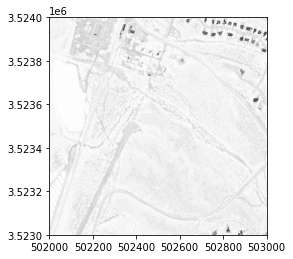

In [26]:
data_plot = plt.imshow(Band_56,extent=cube_ext,cmap='Greys') 

### The image above looks very washed out, and this is due to the range and distribution of reflectance values
#### that we are plotting. We can analyze the data via a histogram to see its distribution.
#### Plot histogram
#### We can plot a histogram using the matplotlib.pyplot.hist function. 
#### Note that this function won't work if there are any NaN values, 
#### so we can ensure we are only plotting the real data values using the call below. 
#### You can also specify the # of bins you want to divide the data into.

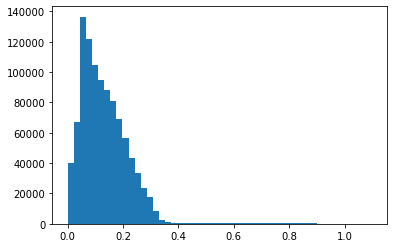

In [27]:
plt.hist(Band_56[~np.isnan(Band_56)],50); #50 signifies the # of bins

In [28]:
### We can see that most of the reflectance values are within the range 0 - 0.4 
#### In order to show more contrast in the image, we can adjust the colorlimit (clim) to 0-0.4 (or 0 to 0.2 only)

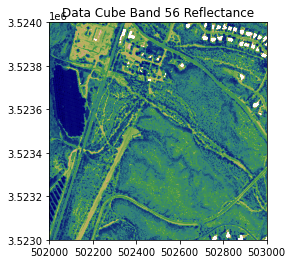

In [29]:
data_plot = plt.imshow(Band_56,extent=cube_ext,cmap='gist_earth',clim=(0,0.4)) 
plt.title('Data Cube Band 56 Reflectance');

### Now that you know how to load a NEON-AOP data cube form HDF 5 data format and read any data from it, let us wortk with the cntent

In [30]:
# Assign some common bands by name and number. Feel free to experiment 
# and use other regions of the spectrum that correspond to the color of interest.
# Review the references slides in the Lab. presentation about where these band numbers come from 
bandRED=48
bandGREEN=34
bandBLUE=17
bandNIR=97

Creating RGB Image...


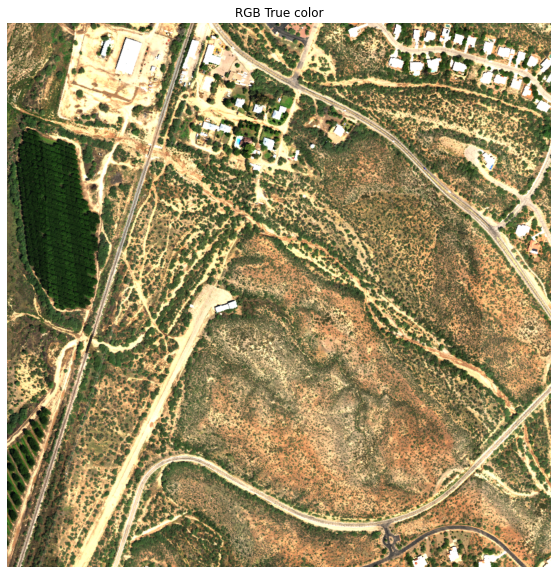

In [46]:
# Combine the Red, Green and Blue data into an RGB image for display
print("Creating RGB Image...")
RGBImage=vip.Image_getRGB(reflArray[:,:,bandRED],reflArray[:,:,bandGREEN],reflArray[:,:,bandBLUE],5000)

# Display RGB True color Image
plt.figure(figsize=(10,10))
plt.title('RGB True color')
plt.axis('off')
plt.imshow(RGBImage) 


Reading RSR: ../Data/Lab_6/NEON_Sentinel2A_RSR.csv
Convolution:
Sensor: SENTINEL2A
Resolution: 10.0 meters
Bands: ['BLUE', 'GREEN', 'RED', 'NIR']


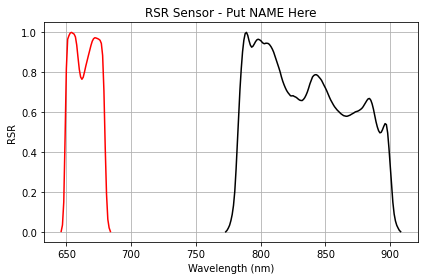

In [36]:
# create Spectral Convolution object
NEON=vipConv.SpecConvolution()

#Load NEON wavelength values that match each NEON band
#WavesList=NEON.Load_Wavesfile('./Data/NEON_wavelength_values.txt')
# Will use the list loaded above 
WavesList=wavelengths

#Load simulated sensor RSR function
NEON.Load_RSR('../Data/Lab_6/NEON_Sentinel2A_RSR.csv')

#display RSR basic information
NEON.displayRSR()

#Retrieve RSR for a specific band
RSR_RED=NEON.getBand_RSR('RED')

RSR_NIR=NEON.getBand_RSR('NIR')

#create a plot of the RSR
plt.figure()
plt.title('RSR Sensor - Put NAME Here')
plt.xlabel('Wavelength (nm)')
plt.ylabel('RSR')

#RSR_RED[:,0] is the X Axis
#RSR_RED[:,1] is the Y Axis
plt.plot(RSR_RED[:,0],RSR_RED[:,1],color='red')
plt.plot(RSR_NIR[:,0],RSR_NIR[:,1],color='black')
plt.grid(True)
plt.tight_layout()
plt.show()


# Now create and add plots for the other bands

In [37]:
#apply convolution to dataset
SENTINELCube=NEON.Spectral_Spatial_Convolution(WavesList,reflArray)

Processing convolution...
 band: BLUE
 min= 440.0 max= 535.0
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 .
 band: GREEN
 min= 537.0 max= 582.0
  32  33  34  35  36  37  38  39  40  41 .
 band: RED
 min= 646.0 max= 684.0
  53  54  55  56  57  58  59  60  61 .
 band: NIR
 min= 773.0 max= 908.0
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106 .
Spatial Resampling at  10.0  [ 100 , 100 ]


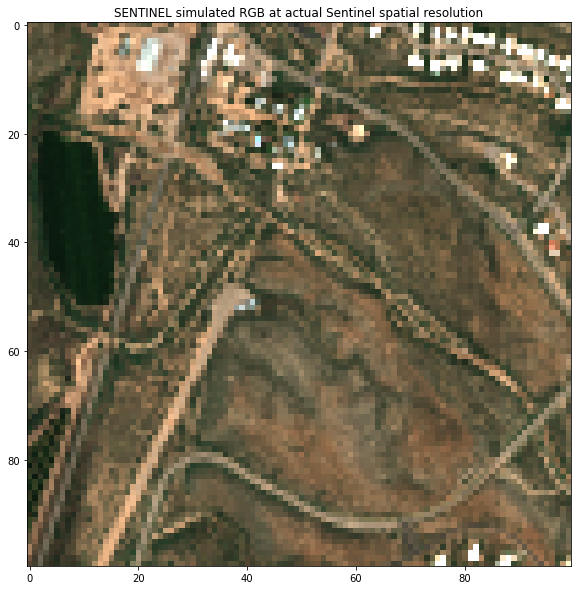

In [38]:
RGBImage=vip.Image_getRGB(SENTINELCube[:,:,2],SENTINELCube[:,:,1],SENTINELCube[:,:,0],8000)
# Display RGB True color Image
plt.figure(figsize=(10,10))
plt.title('SENTINEL simulated RGB at actual Sentinel spatial resolution')
plt.imshow(RGBImage)

In [39]:
# Rerun Convolution at a different spatial resolution, 5 meters
SENTINELCube=NEON.Spectral_Spatial_Convolution(WavesList,reflArray,5)
RGBImage=vip.Image_getRGB(SENTINELCube[:,:,2],SENTINELCube[:,:,1],SENTINELCube[:,:,0],8000)


Processing convolution...
 band: BLUE
 min= 440.0 max= 535.0
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 .
 band: GREEN
 min= 537.0 max= 582.0
  32  33  34  35  36  37  38  39  40  41 .
 band: RED
 min= 646.0 max= 684.0
  53  54  55  56  57  58  59  60  61 .
 band: NIR
 min= 773.0 max= 908.0
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106 .
Spatial Resampling at  5  [ 200 , 200 ]


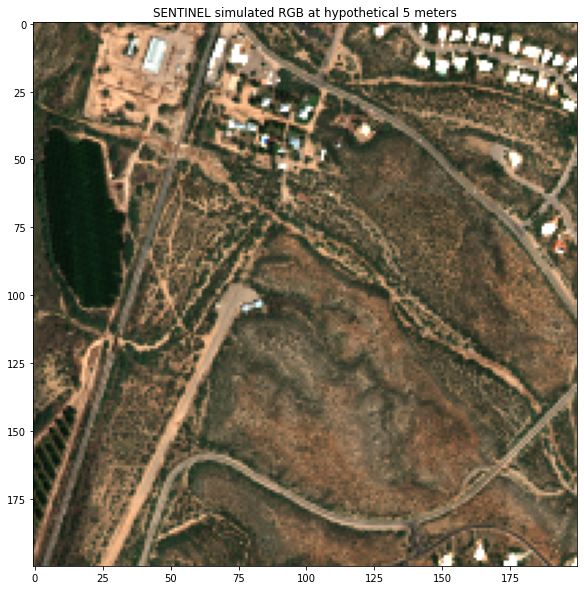

In [40]:
# Display RGB True color Image
plt.figure(figsize=(10,10))
plt.title('SENTINEL simulated RGB at hypothetical 5 meters')
plt.imshow(RGBImage)

In [41]:
# ReRun only spectral Convolution (not spatial) 
SENTINELCube=NEON.Spectral_Convolution(WavesList,reflArray)
RGBImage=vip.Image_getRGB(SENTINELCube[:,:,2],SENTINELCube[:,:,1],SENTINELCube[:,:,0],8000)

Processing convolution...
 band: BLUE
 min= 440.0 max= 535.0
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 .
 band: GREEN
 min= 537.0 max= 582.0
  32  33  34  35  36  37  38  39  40  41 .
 band: RED
 min= 646.0 max= 684.0
  53  54  55  56  57  58  59  60  61 .
 band: NIR
 min= 773.0 max= 908.0
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106 .


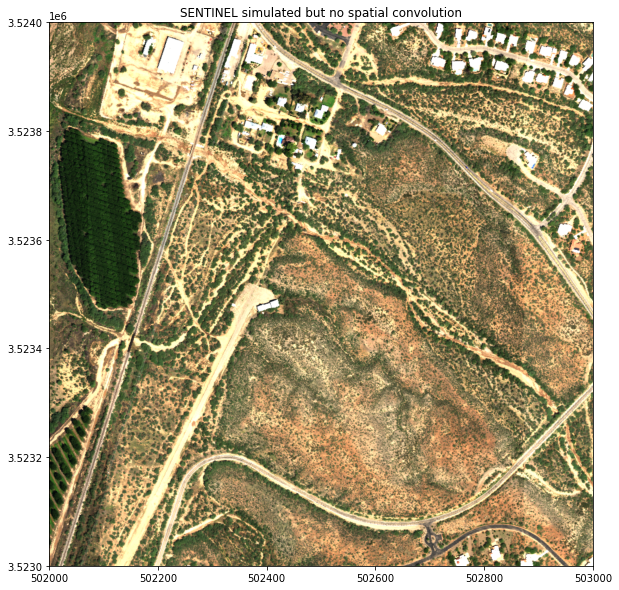

In [47]:
# Display RGB True color Image
plt.figure(figsize=(10,10))
plt.title('SENTINEL simulated but no spatial convolution')
plt.imshow(RGBImage,extent=cube_ext)

## <font color="red">To do </font>
* Use the example code above for Sentinel 2 (ESA platform)
* Simulate the following sensors from NEON: 
* Landsat 8 OLI, MODIS/VIIRS [but at 50m resolution – We do not have enough coverage to simulate the actual 250m/300m data]
* Generate plots/images with all RSRs for all bands and all sensors (like the example above)
* Extract different (objects) Spectral Signatures then plot from original Data Cube and  
* simulated sensor data cube

In [188]:
#display a message the program ended
print("program ended.")

program ended.
